In [1]:
# Function: Process Digital Elevation Models (DEMs) with Python.

# Written by He Zhang, University of Exeter
# Date: Mar 15th 2019
# Contact: hz298@exeter.ac.uk

# DEMs:
#     - ASTER GDEM v2.0 (ASTGDEMv2.0)
#     Download Link: https://earthexplorer.usgs.gov/
#     - EU DEM v1.1 (EUDEMv1.1)
#     Download Link: https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1

# Terms and Abbreviations:
#     EPSG     -  European Petroleum Survey Group
#     GCS      -  Geographic Coordinate System
#     PCS      -  Projected Coordinate System
#     WGS-84   -  1984 World Geodetic System [GCS]
#     OSGB-36  -  1936 Ordnance Survey Great Britain [GCS]
#     BNG      -  British National Grid [PCS of OSGB-36]
#     ETRS-89  -  1989 European Terrestrial Reference System [GCS]

# Functions:
#     For ASTGDEMv2.0:
#         1. Remove the overlapped elements of ASTGDEMv2.0 DEMs (in WGS-84 GCS).
#         2. Merge the reformed ASTGDEMv2.0 DEMs (in WGS-84 GCS).
#         3. Transform the merged ASTGDEMv2.0 DEM (from WGS-84 GCS [EPSG-4326] to OSGB-36 GCS [EPSG-4277]).
#         4. Project the ASTGDEMv2.0 DEM (from WGS-84 GCS to Web Mercator PCS [EPSG-3857]).
#         4. Project the ASTGDEMv2.0 DEM (from OSGB-36 GCS to BNG PCS [EPSG-27700]).
#         5. Display the ASTGDEMv2.0 DEM (in Web Mercator PCS) as a 2D image.
#         5. Display the ASTGDEMv2.0 DEM (in BNG PCS) as a 2D image.
#         6. Get the elevation of air quality monitoring stations from ASTGDEMv2.0 DEM (in WGS-84 GCS).
#         6. Get the elevation of air quality monitoring stations from ASTGDEMv2.0 DEM (in OSGB-36 GCS).
#     For EUDEMv1.1:
#         1. Re-Project the EUDEMv1.1 DEM (from ETRS-LAEA PCS [EPSG-3035] to ETRS-89 GCS [EPSG-4258]).
#         2. Get the elevation of air quality monitoring stations from EUDEMv1.1 DEM (in ETRS-89 GCS).

# **************************** Important Information of Code Usage ****************************
#     - Use 'GDAL.GetProjection()' to check the GCS or PCS of DEMs (in TIF format).
#     - Use 'GDAL.GetGeoTransform()' to check the resolution and the top-left corner location of DEMs.
#     - You can transform DEMs between different GCSs (e.g., WGS-84 <-> OSGB-36 <-> ETRS-89).
#     - Each GCS has one related PCS.
#     - You can project DEM in GCS to the related PCS and then display its 2D image.
#     - You can not display DEM in GCS as 2D image (i.e., imshow(DEMinGCS) is wrong).
#     - You can not project DEM in GCS to the PCS related to another GCS (e.g., WGS-84 <-> BNG is wrong).
#     - You can not transform DEMs between different PCSs (e.g., Web Mercator <-> BNG is wrong)


In [2]:
import os
import re
import shutil
import subprocess

import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from pandas import read_csv



In [3]:
def get_file_names(file_path, file_type):
    '''Get the file names of a specified file type in a folder.

    Parameters:
        file_path <str> -- The path of target folder.
        file_type <str> -- The type of target files (e.g., ".tif").

    Returns:
        file_names <list> -- The name list of target files (e.g., ['ASTGTM2_N51W001_dem.tif', ...]).
    '''
    file_names = []
    files = [file for file in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, file))]
    for file in files:
        if file_type in file:
            file_names.append(file)

    return file_names


def get_dem_info(dem_data, tag_print):
    '''Get and print the parameter information of a DEM in GCS/PCS.

    Parameters:
        dem_data <osgeo.gdal.Dataset> -- The input DEM.
        tag_print <int> -- 1 - Print the parameter information of input DEM; else - Not print.

    Returns:
        The parameters of input DEM.
    '''
    dem_row = dem_data.RasterYSize  # Height.
    dem_col = dem_data.RasterXSize  # Width.
    dem_band = dem_data.RasterCount
    dem_geotran = dem_data.GetGeoTransform()
    dem_proj = dem_data.GetProjection()

    if tag_print == 1:
        print('\n==> DEM parameter information:')
        print('===> The number of rows of DEM is: %d (height).' % dem_row)
        print('===> The number of cols of DEM is: %d (width).' % dem_col)
        print('===> The number of bands of DEM is: %d.' % dem_band)
        print('===> The 6 GeoTransform parameters of DEM is:')
        print(dem_geotran)
        print('===> The projection information of DEM is:')
        print(dem_proj)

    return dem_row, dem_col, dem_band, dem_geotran, dem_proj


def write_dem(dem_array, dem_row, dem_col, dem_band, dem_geotran, dem_proj, path):
    '''Write elevation data to a new DEM (in GCS).

    Parameters:
        dem_array <numpy.ndarray> -- The elevation data.
        dem_row <int> -- The height of DEM.
        dem_col <int> -- The width of DEM.
        dem_band <int> -- The number of bands of DEM.
        dem_geotran <tuple> -- The GeoTransform parameters of DEM.
        dem_proj <str> -- The reference system information of DEM.
        path <str> -- The path for saving new DEM.

    Default settings:
        The data type of DEM is 'gdal.GDT_UInt16'.
        The file format of DEM is 'gdal.GetDriverByName("GTiff")'.

    Returns:
        0 -- If writing DEM is completed.
    '''
    data_type = gdal.GDT_UInt16  # This should be changed for different DEMs.
    if len(dem_array.shape) == 3:
        dem_band, dem_row, dem_col = dem_array.shape
    elif len(dem_array.shape) == 2:
        dem_array = np.array([dem_array])
    else:
        dem_band, (dem_row, dem_col) = 1, dem_array.shape

    driver = gdal.GetDriverByName("GTiff")  # This should be changed for different DEMs.
    dataset = driver.Create(path, dem_col, dem_row, dem_band, data_type)  # col -> row.
    if(dataset is not None):
        dataset.SetGeoTransform(dem_geotran)
        dataset.SetProjection(dem_proj)
    for i in range(dem_band):
        dataset.GetRasterBand(i + 1).WriteArray(dem_array[i])
    del dataset

    return 0


def show_dem_pcs(file_path, file_name, img_path, img_name):
    '''Display the DEM in PCS as a 2D image and save the image.

    Parameters:
        file_path <str> -- The path of target DEM in PCS for display.
        file_name <str> -- The name of target DEM in PCS for display.
        img_path <str> -- The path for saving 2D DEM image.
        img_name <str> -- The name of 2D DEM image.

    Returns:
        0 -- If display and saving are completed.
    '''
    gdal_data = gdal.Open(file_path + file_name)
    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan
    print('\n*==> The shape of the DEM is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))

    # Create the path for saving 2D DEM image.
    if os.path.exists(img_path) is False:
            os.mkdir(img_path)

    print('\n>>>> Plot DEM in PCS as 2D image.')
    fig = plt.figure(figsize=(5, 10))
    plt.title('2D DEM Image of ' + img_name)
    plt.imshow(gdal_array)
    plt.show()
    fig.savefig(img_path + img_name + '.png')

    return 0


def get_elevation(gcs_data, site_latlog):
    '''Get the elevation of specified locations from DEM in GCS.

    Parameters:
        gcs_data <osgeo.gdal.Dataset> -- The input DEM in GCS.
        site_latlog <numpy.ndarray> -- The latitude and longitude of target locations.

    Returns:
        ele <numpy.ndarray> -- The elevation information of target locations.
    '''
    gt = gcs_data.GetGeoTransform()
    print('\n*==> The GeoTransform parameters of DEM are:', gt)

    gcs_array = gcs_data.ReadAsArray().astype(np.float)
    gcs_band = gcs_data.GetRasterBand(1)
    nodataval = gcs_band.GetNoDataValue()
    if np.any(gcs_array == nodataval):
        gcs_array[gcs_array == nodataval] = np.nan

    M = site_latlog.shape[0]
    Xgeo = site_latlog[:, 1]  # Longitude.
    Ygeo = site_latlog[:, 0]  # Latitude.

    ele = np.zeros((M, 6))  # The elevation of M locations.
    for i in range(M):
        # Note:
        #     Xgeo = gt[0] + Xpixel * gt[1] + Yline * gt[2]
        #     Ygeo = gt[3] + Xpixel * gt[4] + Yline * gt[5]
        #
        #     Xpixel - Pixel/column of DEM
        #     Yline - Line/row of DEM
        #
        #     Xgeo - Longitude
        #     Ygeo - Latitude
        #
        #     [0] = Longitude of left-top pixel
        #     [3] = Latitude of left-top pixel
        #
        #     [1] = + Pixel width
        #     [5] = - Pixel height
        #
        #     [2] = 0 for north up DEM
        #     [4] = 0 for north up DEM

        Xpixel = int(round((Xgeo[i] - gt[0]) / gt[1]))
        Yline = int(round((Ygeo[i] - gt[3]) / gt[5]))

        ele[i, 0] = int(i)  # i-th location.
        ele[i, 1] = Ygeo[i]  # Latitude.
        ele[i, 2] = Xgeo[i]  # Longitude.
        ele[i, 3] = Yline  # Row.
        ele[i, 4] = Xpixel  # Column.
        ele[i, 5] = gcs_array[Yline, Xpixel]  # The elevation of i-th location.

    return ele



In [4]:
# Specify the path and type of source/reformed DEMs.

# "..._s/" - The folder of source DEMs.
# "..._r/" - The folder of reformed DEMs.

path_astgdem_source = "DATA/DATA_ASTGDEMv20/EPSG4326_s/"
path_astgdem_reform = "DATA/DATA_ASTGDEMv20/EPSG4326_r/"
path_astgdem = "DATA/DATA_ASTGDEMv20/"

path_eudem_source = "DATA/DATA_EUDEMv11/EPSG3035_s/"
path_eudem = "DATA/DATA_EUDEMv11/"

file_type = ".tif"


In [5]:
# Specify the name and path of DEMs in GCSs.

gcs_path_astgdem = "DATA/DATA_ASTGDEMv20/"
gcs_wgs = "ASTGDEMv20_EPSG4326.tif"
gcs_osgb = "ASTGDEMv20_EPSG4277.tif"

gcs_path_eudem = "DATA/DATA_EUDEMv11/"
gcs_etrs = "EUDEMv11_EPSG4258.tif"


In [6]:
# <ASTGDEMv2.0> Remove the overlapped elements of ASTGDEMv2.0 DEMs (in WGS-84 GCS).

print('\n>>> Remove the overlapped elements of ASTGDEMv2.0 DEMs (in WGS-84 GCS).')

file_names = get_file_names(path_astgdem_source, file_type)
file_names.sort(reverse=True)  # W -> E.
for i, file_name in enumerate(file_names):
    print('\n>>> Process the %d-th DEM: %s.' % (i + 1, file_name))

    gdal_data = gdal.Open(path_astgdem_source + file_name)
    row, col, band, geotran, proj = get_dem_info(gdal_data, 1)
    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    print('\n*==> The shape of DEM is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))

    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan

    gdal_array = np.delete(gdal_array, -1, axis=0)  # Delete the last/bottom row.
    gdal_array = np.delete(gdal_array, -1, axis=1)  # Delete the last/right column.
    print('\n*==> The shape of reformed DEM is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))

    path = path_astgdem_reform
    if os.path.exists(path) is False:
        os.mkdir(path)
    print('\n>>> Write reformed DEM to ' + file_name + '.')
    write_dem(gdal_array, gdal_array.shape[0], gdal_array.shape[1], band, geotran, proj, path + file_name)

print('\n>>> Complete!\n')



>>> Remove the overlapped elements of ASTGDEMv2.0 DEMs (in WGS-84 GCS).

>>> Process the 1-th DEM: ASTGTM2_N51W001_dem.tif.

==> DEM parameter information:
===> The number of rows of DEM is: 3601 (height).
===> The number of cols of DEM is: 3601 (width).
===> The number of bands of DEM is: 1.
===> The 6 GeoTransform parameters of DEM is:
(-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
===> The projection information of DEM is:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]

*==> The shape of DEM is: [3601, 3601].

*==> The shape of reformed DEM is: [3600, 3600].

>>> Write reformed DEM to ASTGTM2_N51W001_dem.tif.

>>> Process the 2-th DEM: ASTGTM2_N51E000_dem.tif.

==> DEM parameter information:
===> The number of rows of DEM is: 3601 (height).
===> The number of cols of DEM is: 

In [7]:
# <ASTGDEMv2.0> Merge the reformed ASTGDEMv2.0 DEMs (in WGS-84 GCS).

print('\n>>> Merge the reformed ASTGDEMv2.0 DEMs (in WGS-84 GCS).')

dem_out = "ASTGDEMv20_EPSG4326.tif"

file_names = get_file_names(path_astgdem_reform, file_type)
file_names.sort(reverse=True)  # W -> E.
dem_merged_array = []
for i, file_name in enumerate(file_names):
    if "ASTGTM2" in file_name:
        print('\n>>> Read the %d-th DEM: %s.' % (i + 1, file_name))

        gdal_data = gdal.Open(path_astgdem_reform + file_name)
        gdal_array = gdal_data.ReadAsArray().astype(np.float)
        print('*==> The shape of DEM is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))

        gdal_band = gdal_data.GetRasterBand(1)
        nodataval = gdal_band.GetNoDataValue()
        if np.any(gdal_array == nodataval):
            gdal_array[gdal_array == nodataval] = np.nan

        # Merge DEM arrays.
        name_lat = re.findall(r'-?\d+\.?\d*', file_name)[1]
        name_log = re.findall(r'-?\d+\.?\d*', file_name)[2]
        if name_lat == '51':  # Not perfect.
            if name_log == '001':
                dem_merged_array = gdal_array
            else:
                dem_merged_array = np.concatenate((dem_merged_array, gdal_array), axis=1)

print('\n*==> The shape of merged DEM is: [%d, %d].' % (dem_merged_array.shape[0], dem_merged_array.shape[1]))

# Set the GeoTransform parameters of merged DEM (according to the left-top DEM block).
gdal_data = gdal.Open(path_astgdem_reform + file_names[0])
row, col, band, geotran, proj = get_dem_info(gdal_data, 0)

path = path_astgdem
if os.path.exists(path) is False:
    os.mkdir(path)
print('\n>>> Write merged DEM to ' + dem_out + '.')
write_dem(dem_merged_array, dem_merged_array.shape[0], dem_merged_array.shape[1], band, geotran, proj, path + dem_out)

print('\n>>> Complete!\n')



>>> Merge the reformed ASTGDEMv2.0 DEMs (in WGS-84 GCS).

>>> Read the 1-th DEM: ASTGTM2_N51W001_dem.tif.
*==> The shape of DEM is: [3600, 3600].

>>> Read the 2-th DEM: ASTGTM2_N51E000_dem.tif.
*==> The shape of DEM is: [3600, 3600].

*==> The shape of merged DEM is: [3600, 7200].

>>> Write merged DEM to ASTGDEMv20_EPSG4326.tif.

>>> Complete!



In [8]:
# <ASTGDEMv2.0> Transform the merged ASTGDEMv2.0 DEM (from WGS-84 GCS [EPSG-4326] to OSGB-36 GCS [EPSG-4277]).

print('\n>>> Transform the merged ASTGDEMv2.0 DEM (from WGS-84 GCS [EPSG-4326] to OSGB-36 GCS [EPSG-4277]).')

path = path_astgdem
dem_in = path + "ASTGDEMv20_EPSG4326.tif"
dem_out = path + "ASTGDEMv20_EPSG4277.tif"

# Check if the output file exists. If so, delete it.
if os.path.isfile(dem_out) is True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4277" + " " + dem_in + " " + dem_out

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Transform the merged ASTGDEMv2.0 DEM (from WGS-84 GCS [EPSG-4326] to OSGB-36 GCS [EPSG-4277]).

>>> Complete!



In [9]:
# <ASTGDEMv2.0> Project the ASTGDEMv2.0 DEM (from WGS-84 GCS to Web Mercator PCS [EPSG-3857]).

print('\n>>> Project the ASTGDEMv2.0 DEM (from WGS-84 GCS to Web Mercator PCS [EPSG-3857]).')

path = path_astgdem
dem_in = path + "ASTGDEMv20_EPSG4326.tif"
dem_out = path + "ASTGDEMv20_EPSG3857.tif"

# Check if the output file exists. If so, delete it.
if os.path.isfile(dem_out) is True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857" + " " + dem_in + " " + dem_out

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Project the ASTGDEMv2.0 DEM (from WGS-84 GCS to Web Mercator PCS [EPSG-3857]).

>>> Complete!



In [10]:
# <ASTGDEMv2.0> Project the ASTGDEMv2.0 DEM (from OSGB-36 GCS to BNG PCS [EPSG-27700]).

print('\n>>> Project the ASTGDEMv2.0 DEM (from OSGB-36 GCS to BNG PCS [EPSG-27700]).')

path = path_astgdem
dem_in = path + "ASTGDEMv20_EPSG4277.tif"
dem_out = path + "ASTGDEMv20_EPSG27700.tif"

# Check if the output file exists. If so, delete it.
if os.path.isfile(dem_out) is True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4277 -t_srs EPSG:27700" + " " + dem_in + " " + dem_out

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Project the ASTGDEMv2.0 DEM (from OSGB-36 GCS to BNG PCS [EPSG-27700]).

>>> Complete!




>>> Display the ASTGDEMv2.0 DEM (in Web Mercator PCS) as a 2D image.

*==> The shape of the DEM is: [5041, 6276].

>>>> Plot DEM in PCS as 2D image.


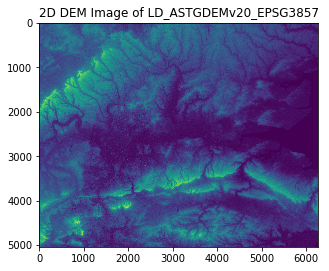


==> DEM parameter information:
===> The number of rows of DEM is: 5041 (height).
===> The number of cols of DEM is: 6276 (width).
===> The number of bands of DEM is: 1.
===> The 6 GeoTransform parameters of DEM is:
(-111334.95183366034, 35.47497364189955, 0.0, 6800150.567328675, 0.0, -35.47497364189955)
===> The projection information of DEM is:
PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs"],AUTHORITY["EPSG","3857"]]

>>> Display the ASTGDEMv2.0 DEM (in BNG PCS) as a 2D 

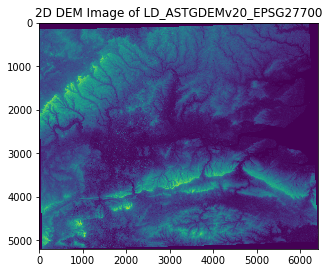


==> DEM parameter information:
===> The number of rows of DEM is: 5203 (height).
===> The number of cols of DEM is: 6418 (width).
===> The number of bands of DEM is: 1.
===> The 6 GeoTransform parameters of DEM is:
(468736.14475350257, 22.101898961294147, 0.0, 237774.34151860897, 0.0, -22.101898961294147)
===> The projection information of DEM is:
PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","27700"]]

>>> Complete!



In [11]:
# <ASTGDEMv2.0> Display the ASTGDEMv2.0 DEM (in Web Mercator PCS) as a 2D image.
# <ASTGDEMv2.0> Display the ASTGDEMv2.0 DEM (in BNG PCS) as a 2D image.

path = path_astgdem
img_path = "IMG/"

# Create the path of folder for saving 2D DEM images.
if os.path.exists(img_path) is True:
    shutil.rmtree(img_path)  # If path exists, delete the path and its contents.
os.mkdir(img_path)

# DEM in Web Mercator PCS.
print('\n>>> Display the ASTGDEMv2.0 DEM (in Web Mercator PCS) as a 2D image.')
dem_name = "ASTGDEMv20_EPSG3857.tif"
img_name = "LD_ASTGDEMv20_EPSG3857"
show_dem_pcs(path, dem_name, img_path, img_name)
data = gdal.Open(path + dem_name)
get_dem_info(data, 1)

# DEM in BNG PCS.
print('\n>>> Display the ASTGDEMv2.0 DEM (in BNG PCS) as a 2D image.')
dem_name = "ASTGDEMv20_EPSG27700.tif"
img_name = "LD_ASTGDEMv20_EPSG27700"
show_dem_pcs(path, dem_name, img_path, img_name)
data = gdal.Open(path + dem_name)
get_dem_info(data, 1)

print('\n>>> Complete!\n')


In [12]:
# <EUDEMv1.1> Get the information of EUDEMv1.1 DEM (~1 min).

print('\n>>> Get the information of EUDEMv1.1 DEM.')

file_names = get_file_names(path_eudem_source, file_type)
for i, file_name in enumerate(file_names):
    print('\n>>> Read the %d-th DEM: %s.' % (i + 1, file_name))

    gdal_data = gdal.Open(path_eudem_source + file_name)
    row, col, band, geotran, proj = get_dem_info(gdal_data, 1)
    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    print('\n*==> The shape of DEM is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))

    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan

print('\n>>> Complete!\n')



>>> Get the information of EUDEMv1.1 DEM.

>>> Read the 1-th DEM: eu_dem_v11_E30N30.tif.

==> DEM parameter information:
===> The number of rows of DEM is: 40000 (height).
===> The number of cols of DEM is: 40000 (width).
===> The number of bands of DEM is: 1.
===> The 6 GeoTransform parameters of DEM is:
(3000000.0, 25.0, 0.0, 4000000.0, 0.0, -25.0)
===> The projection information of DEM is:
PROJCS["ETRS89_ETRS_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]

*==> The shape of DEM is: [40000, 40000].

>>> Complete!



In [13]:
# <EUDEMv1.1> Re-Project the EUDEMv1.1 DEM (from ETRS-LAEA PCS [EPSG-3035] to ETRS-89 GCS [EPSG-4258]) (~3 min).

print('\n>>> Re-Project the EUDEMv1.1 DEM (from ETRS-LAEA PCS [EPSG-3035] to ETRS-89 GCS [EPSG-4258]).')

path = path_eudem
dem_in = path + "EUDEMv11_EPSG3035.tif"
dem_out = path + "EUDEMv11_EPSG4258.tif"

# Check if the output file exists. If so, delete it.
if os.path.isfile(dem_out) is True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:3035 -t_srs EPSG:4258" + " " + dem_in + " " + dem_out

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Re-Project the EUDEMv1.1 DEM (from ETRS-LAEA PCS [EPSG-3035] to ETRS-89 GCS [EPSG-4258]).

>>> Complete!



In [14]:
# Read the information of London air quality monitoring stations.

print('\n>>> Read the information of London air quality monitoring stations.')

site_path = "DATA/DATA_LD_AirQuality/London_AirQuality_Stations.csv"
site_data_raw = read_csv(site_path)
print(site_data_raw.head(3))

site_num = site_data_raw['SiteName'].count()
print('\n*==> The number of stations is: %d.' % site_num)

site_latlog = np.zeros((site_num, 2))  # The latitude and longitude of stations.
site_latlog[:, 0] = site_data_raw['Latitude']  # 0-th column - Latitude.
site_latlog[:, 1] = site_data_raw['Longitude']  # 1-th column - Longitude.

np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print('\n*==> The latitude and longitude of stations are:')
print(site_latlog)

print('\n>>> Complete!\n')



>>> Read the information of London air quality monitoring stations.
  Unnamed: 0 api_data need_prediction  historical_data   Latitude  Longitude  \
0        BX9     True             NaN             True  51.465983   0.184877   
1        BX1     True             NaN             True  51.465983   0.184877   
2        BL0     True            True             True  51.522287  -0.125848   

           SiteType                   SiteName  
0          Suburban  Bexley - Slade Green FDMS  
1          Suburban       Bexley - Slade Green  
2  Urban Background        Camden - Bloomsbury  

*==> The number of stations is: 24.

*==> The latitude and longitude of stations are:
[[51.46598327  0.18487713]
 [51.46598327  0.18487713]
 [51.522287   -0.125848  ]
 [51.52770662 -0.12905321]
 [51.544219   -0.175284  ]
 [51.51452534 -0.10451563]
 [51.51384718 -0.07776568]
 [51.410039   -0.127523  ]
 [51.490532    0.074003  ]
 [51.45258     0.070766  ]
 [51.486957    0.095111  ]
 [51.456357    0.040725  ]
 [5

In [15]:
# <ASTGDEMv2.0> Get the elevation of air quality monitoring stations from ASTGDEMv2.0 DEM (in WGS-84 GCS).

print('\n>>> Get the elevation of air quality monitoring stations from ASTGDEMv2.0 DEM (in WGS-84 GCS).')

gcs_data = gdal.Open(gcs_path_astgdem + gcs_wgs)

get_dem_info(gcs_data, 1)

# Get elevation.
site_ele_wgs = get_elevation(gcs_data, site_latlog)
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.

print('\n*==> The detailed elevation of stations is:')
print(site_ele_wgs)
print('\n*==> The summarized elevation of stations is:')
print(site_ele_wgs[:, 5].astype(int))

print('\n>>> Complete!\n')



>>> Get the elevation of air quality monitoring stations from ASTGDEMv2.0 DEM (in WGS-84 GCS).

==> DEM parameter information:
===> The number of rows of DEM is: 3600 (height).
===> The number of cols of DEM is: 7200 (width).
===> The number of bands of DEM is: 1.
===> The 6 GeoTransform parameters of DEM is:
(-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
===> The projection information of DEM is:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]

*==> The GeoTransform parameters of DEM are: (-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)

*==> The detailed elevation of stations is:
[[   0.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   1.           51.46598327    0.18487713 1923.         4266.
    18. 

In [16]:
# <ASTGDEMv2.0> Get the elevation of air quality monitoring stations from ASTGDEMv2.0 DEM (in OSGB-36 GCS).

print('\n>>> Get the elevation of air quality monitoring stations from ASTGDEMv2.0 DEM (in OSGB-36 GCS).')

gcs_data = gdal.Open(gcs_path_astgdem + gcs_osgb)

get_dem_info(gcs_data, 1)

# Get elevation.
site_ele_osgb = get_elevation(gcs_data, site_latlog)
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.

print('\n*==> The detailed elevation of stations is:')
print(site_ele_osgb)
print('\n*==> The summarized elevation of stations is:')
print(site_ele_osgb[:, 5].astype(int))

print('\n>>> Complete!\n')



>>> Get the elevation of air quality monitoring stations from ASTGDEMv2.0 DEM (in OSGB-36 GCS).

==> DEM parameter information:
===> The number of rows of DEM is: 3600 (height).
===> The number of cols of DEM is: 7200 (width).
===> The number of bands of DEM is: 1.
===> The 6 GeoTransform parameters of DEM is:
(-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)
===> The projection information of DEM is:
GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]]

*==> The GeoTransform parameters of DEM are: (-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)

*==> The detailed elevation of stations is:
[[   0.           51.46598327    0.18487713 1921.         4260.
    14.  

In [17]:
# <EUDEMv1.1> Get the elevation of air quality monitoring stations from EUDEMv1.1 DEM (in ETRS-89 GCS) (~1 min).

print('\n>>> Get the elevation of air quality monitoring stations from EUDEMv1.1 DEM (in ETRS-89 GCS).')

gcs_data = gdal.Open(gcs_path_eudem + gcs_etrs)

get_dem_info(gcs_data, 1)

# Get elevation.
site_ele_etrs = get_elevation(gcs_data, site_latlog)
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.

print('\n*==> The detailed elevation of stations is:')
print(site_ele_etrs)
print('\n*==> The summarized elevation of stations is:')
print(site_ele_etrs[:, 5].astype(int))

print('\n>>> Complete!\n')



>>> Get the elevation of air quality monitoring stations from EUDEMv1.1 DEM (in ETRS-89 GCS).

==> DEM parameter information:
===> The number of rows of DEM is: 30505 (height).
===> The number of cols of DEM is: 52428 (width).
===> The number of bands of DEM is: 1.
===> The 6 GeoTransform parameters of DEM is:
(-12.266271034206424, 0.00033920980218715875, 0.0, 58.98761768429964, 0.0, -0.00033920980218715875)
===> The projection information of DEM is:
GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]]

*==> The GeoTransform parameters of DEM are: (-12.266271034206424, 0.00033920980218715875, 0.0, 58.98761768429964, 0.0, -0.00033920980218715875)

*==> The detailed elevation of stations is:
[[    0.            51.46598327     0.18487713 22174.
  36706.            12.635519

In [18]:
# Compare the elevation of stations obtained from different DEMs.

print('\n>>> Compare the elevation of stations obtained from different DEMs.')

print('\nWGS-84  ', site_ele_wgs[:, 5].astype(int))  # ASTGDEM-v2.0 data in WGS-84 GCS.
print('\nOSGB-36 ', site_ele_osgb[:, 5].astype(int))  # ASTGDEM-v2.0 data in OSGB-36 GCS.
print('\nOSGB-36 ', site_ele_etrs[:, 5].astype(int))  # EUDEM-v1.1 data in ETRS-89 GCS.

print('\n>>> Complete!\n')



>>> Compare the elevation of stations obtained from different DEMs.

WGS-84   [18 18 38 40 65 26 35 31 17 79 13 41 62 82  9 13 31 31 15 22 24 40  8 40]

OSGB-36  [14 14 36 25 60 37 33 40 20 68 12 25 62 59 15 18 22 22 15 21 14 33  8 47]

OSGB-36  [12 12 37 30 61 25 29 36 11 66 11 31 64 79  7 27 25 25 14 15 13 32  5 36]

>>> Complete!

